# Filtado de mensajes spam

## Descripción del problema real

La recepción de publicidad no deseada a traves mensajes de texto usando SMS (Short Message Service) es un problema que afecta a muchos usuarios de teléfonos móviles. El problema radica en que los usuarios deben pagar por los mesajes recibidos, y por este motivo resulta muy importante que las compañías prestadoras del servicio puedan filtrar mensajes indeseados antes de enviarlos a su destinatario final. Los mensajes tienen una longitud máxima de 160 caracteres, por lo que el texto resulta poco para realizar la clasificación, en comparación con textos más largos (como los emails). Adicionalmente, los errores de digitación dificultan el proceso de detección automática.

## Descripción del problema en términos de los datos

Se tiene una muestra contiene 5574 mensajes en inglés, no codificados y clasificados como legítimos (ham) o spam (http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). La información está almacenada en el archivo `datos/spam-sms.zip`.El problema en términos de los datos consiste en clasificar si un mensaje SMS es legítico o spam, a partir del análisis de las palabras que contiente, partiendo del supuesto de que ciertas palabras que son más frecuentes dependiendo del tipo de mensaje. Esto implica que en la fase de preparación de los datos se deben extraer las palabras que contiene cada mensaje para poder realizar el análsis.

## Aproximaciones posibles

En este caso, se desea comparar los resultados de un modelo de redes neuronales artificiales y otras técnicas estadísticas para realizar la clasificación.

## Requerimientos

Usted debe:

* Preprocesar los datos para representarlos usando bag-of-words.


* Construir un modelo de regresión logística como punto base para la comparación con otros modelos más complejos.


* Construir un modelo de redes neuronales artificiales. Asimismo, debe determinar el número de neuronas en la capa o capas ocultas.


* Utiizar una técnica como crossvalidation u otra similar para establecer la robustez del modelo.


* Presentar métricas de desempeño para establecer las bondades y falencias de cada clasificador.

# Solución

## Librerias 
Se importan las librrias necesarias para trabajar

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
from random import seed
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,classification_report
from sklearn.model_selection import train_test_split,cross_val_score, KFold, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from scipy.stats import sem
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

%matplotlib inline
seed(1) 

## Importación de la data
Se importa el dataset que esta en la carpeta de datos y fue obtenido del link provisto por el profesor anteriormente

In [27]:
sms = pd.read_csv('./datos/SMSSpamCollection.txt',sep="\t", header=None,encoding='latin-1')
sms.columns=["etiqueta", "mensaje_sms"]
sms.head()

,etiqueta,mensaje_sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Examinación de la data
Se examina cuantos mensajes son lejitimos (ham)  y cuantos son suplantados (spam)

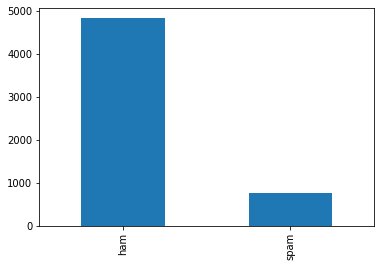

In [28]:
sms.etiqueta.value_counts().plot.bar();

In [33]:
sms.shape

(5572, 2)

Son muy pocos los mensajes etiquetados como spam contra los etiquetados como ham. Para facilitar el entrenamiento y predicción del algoritmo de clasificación que se vaya a utilizar, se codificara la variable de salida para ser binaria, es decir 0 si es lejitimo (ham) y 1 si es ilejitimo o falso (spam)

In [29]:
# Conversion
sms['etiqueta'] = sms.etiqueta.map({'ham':0, 'spam':1})
# Visualizar las dimensiones de los datos
sms.head()

,etiqueta,mensaje_sms
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


## Preparación y partición de set de datos 
Se parten los datos en entrenamiento y validación: 25% datos para validacion y 75% para entrenamiento

In [31]:
# Dividir los datos en conjunto de entrenamiento y de test

X_train, X_test, y_train, y_test = train_test_split(sms['mensaje_sms'], sms['etiqueta'], test_size=0.25, random_state=1)
print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 5572
Number of rows in the training set: 4179
Number of rows in the test set: 1393


El conjunto de datos es una gran coleccion de mensajes de texto (en texto plano) (5572 mensajes). Como los modelos solo aceptarán datos numéricos como entrada, se deben procesar los mensajes de texto para convertir. Aquí es donde se aplica “Bag of Words“ entra en juego.

“Bag of Words” es un término usado para especificar los problemas que tiene una colección de datos de texto que necesita ser procesada, y trata a cada palabra como un token, de forma independiente y sin darle importancia al orden. La idea es tomar un fragmento de texto y contar la frecuencia de las palabras en el mismo.

Se convierte un conjunto de documentos en una matriz, siendo cada documento una fila y cada palabra (token) una columna, y los valores correspondientes (fila, columna) son la frecuencia de ocurrencia de cada palabra (token) en el documento.

Para realizar esto, se utilizara la función de sklearn CountVectorizer()  de la libreria sklearn.feature_extraction.text. Esto se debe aplicar tanto a la data de entrenamiento como a la data de validación y son dos matrices aparte.

In [57]:
##Instanciar el objeto countvectorizer, se aplica stop_words para 
count_vector = CountVectorizer(stop_words='english')
# obtener la matriz de conteo de la data de entrenamiento
training_data = count_vector.fit_transform(X_train)
# TSe aplica el countvector al set de datos de validación para obtener la segunda matriz
testing_data = count_vector.transform(X_test)

## Desarrollo Modelos de predicción
Se procede a desarrollar diferentes modelos para prubar su robustez y efectividad en la clasificación de los mensajes de spam. Cada modelo primero se entrenara con la data de entrenamiento, la cual fue preprocesada con BoW y luego se procedera a evaluar su capacidad de predicción con la data de test, la cual tambien fue previamente preprocesada con BoW. Se tendra como base de comparación la regresión logistica, como se especifico en el enunciado.

La capacidad de predicción de los modelos se evaluara contrastando las predicciones que realicen para la data de test (Xtest), con la salida veridica de cada uno de estos registros (ytest), esto se hara por medio de metricas especializadas para modelos de machine learning e inteligencia artificial. Las metricas que se utilizaran para evaluar la robustez de los modelos seran:

- Accuracy 
- Precision
- Recall
- F1

En la siguiente imagen se especifica la formula para cada metrica. Estas se basan en los verdaderos positivos (true positives TP), verdaderos negativos (true negatives TN), falsos positivos (false positive FP) y falsos negativos (false negatives FN):

<img src="https://miro.medium.com/max/1842/1*7iCBfKN5tMOFFD6hNHG4JQ.png">

Ademas de las metricas enunciadas anteriormente, tambien se evaluara la robustez del modelo con la matriz de confusión, la cual hace mas explicito observar la cantidad de falsos positivos, falsos negativos, verdaderos positivos y verdaderos negativos predichos por el modelo. Tiene la siguiente estructura: 

<img src="https://cdn-images-1.medium.com/max/1000/1*BTB9weIUfSsSRy5kvh_-uA.png">


In [59]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Implementación Regresión Logistica
Se procede  implementar un modelo de regresión logistica, primero se entrenara con la data de train

Prueba y validación

In [74]:
predictions = LR.predict(testing_data)

Obtención de metricas para el modelo de regresion lineal

In [75]:
print('Accuracy score: ', format(accuracy_score(y_test, predictions)))
print('Precision score: ', format(precision_score(y_test, predictions)))
print('Recall score: ', format(recall_score(y_test, predictions)))
print('F1 score: ', format(f1_score(y_test, predictions)))
print('-----------------------------------------------------------------------------')
print (classification_report(y_test, predictions))

Accuracy score:  0.9117013639626705
Precision score:  1.0
Recall score:  0.33513513513513515
F1 score:  0.5020242914979757
-----------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1208
           1       1.00      0.34      0.50       185

    accuracy                           0.91      1393
   macro avg       0.95      0.67      0.73      1393
weighted avg       0.92      0.91      0.89      1393



Matriz de confusión

Confusion matrix, without normalization
[[  62  123]
 [   0 1208]]


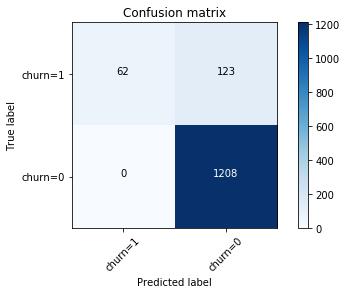

In [76]:
# Compute confusion matrix

cnf_matrix = confusion_matrix(y_test, predictions, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= False,  title='Confusion matrix')

El modelo de regresión lineal se probo con varios tipos de solver y variando el valor del parametro C, pero no se observaron cambios en las metricas evaluadas. El desempeño de este modelo presenta una buena clasificacion de los verdaderos negativos (mensajes clasificados como no spam que en verdad son no spam), tambien es bueno identificando falsos positivos (mensajes no spam clasificados como spam). Sin embargo se raja con los verdaderos positivos (menajes spam clasificados como spam) y los falsos negativos (mensajes que son spam pero se clasifican como no spam). Lo mas rescatable es que no clasifica ningun mensaje no spam como spam, es decir, todos los mensajes autenticos (ham) se clasifican como son.

### Implementación Naive Bayes
Entrenamiento

In [80]:
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

validación y prueba

In [81]:
predictions = naive_bayes.predict(testing_data)

Se procede a obtener las metricas del modelo Naive Bayes

In [82]:

print('Accuracy score: ', format(accuracy_score(y_test, predictions)))
print('Precision score: ', format(precision_score(y_test, predictions)))
print('Recall score: ', format(recall_score(y_test, predictions)))
print('F1 score: ', format(f1_score(y_test, predictions)))
print('-----------------------------------------------------------------------------')
print (classification_report(y_test, predictions))

Accuracy score:  0.9892318736539842
Precision score:  0.9722222222222222
Recall score:  0.9459459459459459
F1 score:  0.9589041095890412
-----------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1208
           1       0.97      0.95      0.96       185

    accuracy                           0.99      1393
   macro avg       0.98      0.97      0.98      1393
weighted avg       0.99      0.99      0.99      1393



Tambien se aplica la matriz de confusión

Confusion matrix, without normalization
[[ 175   10]
 [   5 1203]]


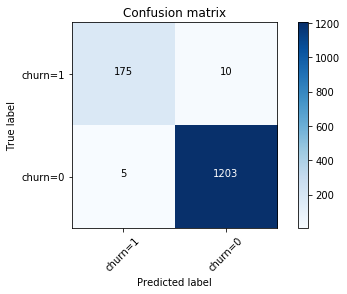

In [83]:
# Compute confusion matrix

cnf_matrix = confusion_matrix(y_test, predictions, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= False,  title='Confusion matrix')

El modelo Naive Bayes tiene muy buen desempeño, presenta altos valores en las metricas evaluadas y su matriz de confusión muestra que los falsos positivos y los falsos negativos son muy pocos comparados con los verdaderos positivos y aun mas con los verdaderos negativo. Es un muy buen modelo, aunque deja filtrar mensajes de spam como si no fueran spam pero lo mas grave es que clasifica mensajes no spam como spam

### Implementación maquina de soporte vectorial (SVM)
Entrenamiento

In [84]:
clf = svm.SVC()
clf.fit(training_data, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Validación y prueba

In [85]:
predictions = clf.predict(testing_data)

Metricas de SVM

In [86]:
print('Accuracy score: ', format(accuracy_score(y_test, predictions)))
print('Precision score: ', format(precision_score(y_test, predictions)))
print('Recall score: ', format(recall_score(y_test, predictions)))
print('F1 score: ', format(f1_score(y_test, predictions)))
print('-----------------------------------------------------------------------------')
print (classification_report(y_test, predictions))

Accuracy score:  0.9820531227566404
Precision score:  1.0
Recall score:  0.8648648648648649
F1 score:  0.927536231884058
-----------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1208
           1       1.00      0.86      0.93       185

    accuracy                           0.98      1393
   macro avg       0.99      0.93      0.96      1393
weighted avg       0.98      0.98      0.98      1393



Confusion matrix, without normalization
[[ 160   25]
 [   0 1208]]


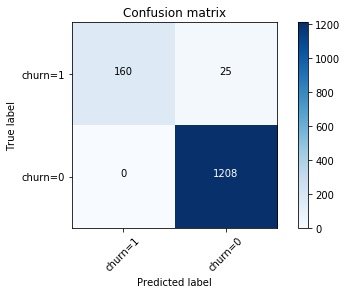

In [87]:
# Compute confusion matrix

cnf_matrix = confusion_matrix(y_test, predictions, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= False,  title='Confusion matrix')

Aunque la maquina de soporte vectorial presenta mejores resultados que la regresión logistica y tiene una tasa de cero falsos positivos (mensajes que se clasifican como spam pero no lo son), presenta una tasa mayor de falsos negativos (mensajes spam clasificados como no spam) es decir, deja filtrar mensajes de spam. Lo mas rescatable es que no clasifica ningun mensaje no spam como spam, es decir, todos los mensajes autenticos (ham) se clasifican como son.

### Red Neuronal MLPClassifier

Se evaluara un modelo Perceptron clasificador multi capa (Multi-layer Perceptron classifier) y el numero de neuronas por capa oculta y numero de capas ocultas a tener encuenta. Este se evaluara con cross validation

In [90]:
#
# Evalua el clasificador usando validación cruzada
#


def evaluate_cross_validation(clf, X, y, n_splits):

    # Crea el objeto para partir los datos
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=8)

    # Realiza la partición para la muestra de datos de entrenamiento
    cv = kf.get_n_splits(X)

    # Ejecuta el entrenamiento para cada partifición
    scores = cross_val_score(clf, X, y, cv=cv, scoring = 'neg_mean_squared_error')

    # Reporta los resultados
    return(scores)

Primero evaluamos el numero de neuronas por capa oculta

In [ ]:

parameter_space = {
    'hidden_layer_sizes': [(1,),(2,),(3,),(4,),(5,),(6,),(7,),(8,),(9,),(10,),(12,),(14,),(16,),(18,),(20,),
                           (25,),(30,),(35,),(40,),(45,),(50,),
                           (50,50,50),(100,),(50,100,50)],
}

regresor = MLPClassifier(max_iter = 10000)


clf1 = GridSearchCV(regresor, parameter_space, n_jobs=-1, cv=10)
clf1.fit(training_data, y_train)

## Conclusiones

- Para poder procesar cadena de caracteres, como son los sms (mensajes de texto), se hace necesario preprocesar la información para obtener una matriz numerica que los diferentes modelos puedan utilizar para entrenarse y predecir. Para esto se hizo uso de la tecnica BoW (Bag of Words), la cual tokeniza las palabras y entrega una matriz donde cada fila corresponde a un sms o cadeja de caracter de la data de entrada (mensaje de texto) y cada columna es una palabra y la intersección fila columna es un numero que dice cuantas veces se repite dicha palabra en dicho sms. Esta matriz se obtiene tanto para la data de entrenamiento como para la data de predicción. Este procesamiento se puede llevar acabo con la libreria sklearn y su modulo de preprosesamiento CountVectorizer.
- Cuando la cantidad de mensajes o cadena de caracteres a analizar es muy grande, palabras comunes del idioma (por ejemplo 'el', 'es', 'la' entre otros; o ingles 'the', 'a', 'of', 'and' etc) pueden cesgar el entrenamiento del modelo, es prudente eliminar estas palabras para tener una data mas limpia para trabajar. Este proceso de limpieza puede llevarse acabo con una propiedad de CountVectorizer llamada stop_words, a la cual se le puede pasar una lista de palabras a tener encuenta para eliminar o si el idioma de la data analizada es ingles, la libreria ya tiene una lista de palabras lista para usar con solo poner 'english' como parametro como se hizo en este ejercicio.
- Los modelos evaluados presentaron en general muy buen desempeño. Se destaca el modelo de Naive Bayes y la maquina de soporte vectorial. Para elegir un modelo u otro se debe entender que se quiere del modelo, ya que por ejemplo el modelo de Naive Bayes presenta muy buenas metricas y muy bajas tasas de falsos negativos (es decir, mensajes spam que se clasifican como no spam) loq ue queire decir que no deja filtrar muchos mensajes spam, pero tiene una falencia y es que tiene una tasa, aunque sea pequeña, de falsos positivos (mensajes clasificados como spam que no son spam) es decir, que clasifica como spam mensajes legitimos, lo cual podria llevar a una perdida de información que puede ser grave en algun punto, segun sea la necesidad. Pro otra parte, los modelos como la maquina de soporte vectorial y regresión logistica, aunque presentan una tasa moderada (y mayor al modelo de Naive) de falsos negativos, es decir dejan filtrar mensajes spam, presentan una tasa 0 de falsos positivos, es decir no se pierden mensajes legitimos por clasificarlos como spam.